# 0. 准备步骤，导包加载数据

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
batch_size = 256
epoch = 50
latent_space_dim = 2
hidden_space_dim = 400
img_size = 784

In [3]:
dataset = torchvision.datasets.MNIST(root='./data/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [4]:
for data in data_loader:
    break

In [5]:
data[0].shape

torch.Size([256, 1, 28, 28])

# 1. 构建编码器

In [6]:
from torch import nn
import torch.nn.functional as F 
import torch
import numpy as np

In [8]:
class vaeLinearEncoder(nn.Module):
    def __init__(self):
        super(vaeLinearEncoder,self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(img_size,img_size),
            # 激活函数十分重要，在VAE中必须保证非负，否则会很难训练
            nn.ReLU(),
            nn.Linear(img_size,hidden_space_dim),
            nn.ReLU(),
            nn.Linear(hidden_space_dim,hidden_space_dim),
            nn.ReLU(),
        )
    def forward(self,inputs):
        out = self.linears(inputs)
        return out

# 2.构建解码器

In [10]:
class vaeLinearDecoder(nn.Module):
    def __init__(self):
        super(vaeLinearDecoder,self).__init__()
        self.linears = nn.Sequential(
            nn.Linear(latent_space_dim,hidden_space_dim),
            nn.ReLU(),
            nn.Linear(hidden_space_dim,hidden_space_dim),
            nn.ReLU(),
            nn.Linear(hidden_space_dim,img_size),
            # 这个sigmoid可以换tanh。或者其他类似的，必须保证非线性和非负
            nn.Sigmoid(),
        )
    def forward(self,z_hidden):
        imgs_re = self.linears(z_hidden)
        return imgs_re

# 3. 准备VAE的中间变量随机采样过程

In [12]:
class VAEModelv2(nn.Module):
    def __init__(self):
        super(VAEModelv2,self).__init__()
        
        self.encoder = vaeLinearEncoder()
        self.decoder = vaeLinearDecoder()
        
        self.fitting_mean = nn.Linear(in_features=hidden_space_dim,out_features=latent_space_dim)
        self.fitting_log_var = nn.Linear(in_features=hidden_space_dim,out_features=latent_space_dim)
        
    def forward(self,imgs):
        x_hidden = self.encoder(imgs)
        
        mean_pred = self.fitting_mean(x_hidden)
        log_var_pred = self.fitting_log_var(x_hidden)
        
        # sample from N(0,I)
        # re-parameter skill
        std = torch.exp(log_var_pred/2)
        eps = torch.randn_like(std)
        z = mean_pred + eps * std
        #miu_norm = torch.randn_like(x_hidden)
        #z = torch.exp(log_var_pred) * miu_norm + mean_pred
        
        imgs_re = self.decoder(z)
        
        reconst_loss = F.binary_cross_entropy(imgs_re, imgs, size_average=False)
        
        kl_div = - 0.5 * torch.sum(1 + log_var_pred - mean_pred.pow(2) - log_var_pred.exp())
        
        return imgs_re,kl_div,reconst_loss

# 4. 训练过程

In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.utils import save_image

In [14]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [15]:
vae = VAEModelv2().cuda()
loss_log_list = []
kl_log = []
reconst_log = []

In [16]:
optimizer = torch.optim.Adam(
    vae.parameters(),
    lr=1e-4
)

In [17]:
for i in tqdm(range(epoch)):
    for j,(imgs,labels) in enumerate(data_loader):
        imgs = imgs.view(-1,784)
        imgs = imgs.cuda()
        imgs_re,kl_div,reconst_loss = vae(imgs)
        loss = reconst_loss + kl_div
        #break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)
        loss_log_list.append(loss.detach().cpu().numpy().tolist())
        kl_log.append(kl_div.detach().cpu().numpy().tolist())
        reconst_log.append(reconst_loss.detach().cpu().numpy().tolist())
        #break
        if j % 25 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(i+1, epoch, j+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, latent_space_dim).to(torch.device("cuda"))
        out = vae.decoder(z).view(-1, 1, 28, 28)
        save_image(out, 'vae_mnist/sampled-{}.png'.format(epoch+1))

        # 重构的图像
        out, _, _ = vae(imgs)
        x_concat = torch.cat([imgs.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, 'vae_mnist/reconst-{}.png'.format(epoch+1))
    #break


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]D:\Anaconda3\envs\bishe\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/50], Step [1/235], Reconst Loss: 139438.4688, KL Div: 0.1756
Epoch[1/50], Step [26/235], Reconst Loss: 115899.5625, KL Div: 376.4882
Epoch[1/50], Step [51/235], Reconst Loss: 61168.1484, KL Div: 3713.4788
Epoch[1/50], Step [76/235], Reconst Loss: 54114.5156, KL Div: 2879.5508
Epoch[1/50], Step [101/235], Reconst Loss: 53325.9141, KL Div: 2292.6157
Epoch[1/50], Step [126/235], Reconst Loss: 54222.3398, KL Div: 1682.3657
Epoch[1/50], Step [151/235], Reconst Loss: 51204.0312, KL Div: 1728.4729
Epoch[1/50], Step [176/235], Reconst Loss: 51902.8789, KL Div: 1457.7815
Epoch[1/50], Step [201/235], Reconst Loss: 51156.8828, KL Div: 1308.7207
Epoch[1/50], Step [226/235], Reconst Loss: 51293.5625, KL Div: 1199.7246


  2%|█▋                                                                                 | 1/50 [00:05<04:13,  5.17s/it]

Epoch[2/50], Step [1/235], Reconst Loss: 50965.0234, KL Div: 1272.9788
Epoch[2/50], Step [26/235], Reconst Loss: 50686.8672, KL Div: 1159.6697
Epoch[2/50], Step [51/235], Reconst Loss: 51285.3438, KL Div: 1050.4635
Epoch[2/50], Step [76/235], Reconst Loss: 49076.7109, KL Div: 1148.2393
Epoch[2/50], Step [101/235], Reconst Loss: 49618.9609, KL Div: 1023.9872
Epoch[2/50], Step [126/235], Reconst Loss: 50224.0625, KL Div: 882.2498
Epoch[2/50], Step [151/235], Reconst Loss: 48420.9180, KL Div: 1001.0176
Epoch[2/50], Step [176/235], Reconst Loss: 50486.7500, KL Div: 834.4238
Epoch[2/50], Step [201/235], Reconst Loss: 47762.2500, KL Div: 901.6809
Epoch[2/50], Step [226/235], Reconst Loss: 48678.3516, KL Div: 859.7316


  4%|███▎                                                                               | 2/50 [00:09<03:49,  4.77s/it]

Epoch[3/50], Step [1/235], Reconst Loss: 46843.7578, KL Div: 898.5035
Epoch[3/50], Step [26/235], Reconst Loss: 47629.6719, KL Div: 864.5609
Epoch[3/50], Step [51/235], Reconst Loss: 48382.4570, KL Div: 826.8862
Epoch[3/50], Step [76/235], Reconst Loss: 48295.8281, KL Div: 863.6021
Epoch[3/50], Step [101/235], Reconst Loss: 48895.5234, KL Div: 802.6970
Epoch[3/50], Step [126/235], Reconst Loss: 47897.8594, KL Div: 863.3555
Epoch[3/50], Step [151/235], Reconst Loss: 46087.8281, KL Div: 958.8229
Epoch[3/50], Step [176/235], Reconst Loss: 44981.6250, KL Div: 1005.5405
Epoch[3/50], Step [201/235], Reconst Loss: 46936.4336, KL Div: 951.7296
Epoch[3/50], Step [226/235], Reconst Loss: 46695.1875, KL Div: 929.7834


  6%|████▉                                                                              | 3/50 [00:14<03:38,  4.64s/it]

Epoch[4/50], Step [1/235], Reconst Loss: 46719.0117, KL Div: 969.0922
Epoch[4/50], Step [26/235], Reconst Loss: 44793.6406, KL Div: 1015.1681
Epoch[4/50], Step [51/235], Reconst Loss: 44919.5859, KL Div: 1016.2573
Epoch[4/50], Step [76/235], Reconst Loss: 45087.1836, KL Div: 1010.2789
Epoch[4/50], Step [101/235], Reconst Loss: 45564.4336, KL Div: 1007.6401
Epoch[4/50], Step [126/235], Reconst Loss: 44956.0000, KL Div: 1027.8612
Epoch[4/50], Step [151/235], Reconst Loss: 44730.4453, KL Div: 1030.6545
Epoch[4/50], Step [176/235], Reconst Loss: 44614.2539, KL Div: 1081.0105
Epoch[4/50], Step [201/235], Reconst Loss: 44760.1484, KL Div: 1207.0326
Epoch[4/50], Step [226/235], Reconst Loss: 43615.7266, KL Div: 1138.8462


  8%|██████▋                                                                            | 4/50 [00:18<03:30,  4.57s/it]

Epoch[5/50], Step [1/235], Reconst Loss: 43161.9688, KL Div: 1117.1066
Epoch[5/50], Step [26/235], Reconst Loss: 44728.0977, KL Div: 1171.1125
Epoch[5/50], Step [51/235], Reconst Loss: 42999.1953, KL Div: 1188.3308
Epoch[5/50], Step [76/235], Reconst Loss: 41942.4414, KL Div: 1235.2295
Epoch[5/50], Step [101/235], Reconst Loss: 43385.0742, KL Div: 1111.1316
Epoch[5/50], Step [126/235], Reconst Loss: 43172.0938, KL Div: 1184.0920
Epoch[5/50], Step [151/235], Reconst Loss: 42832.0195, KL Div: 1171.5465
Epoch[5/50], Step [176/235], Reconst Loss: 42680.7148, KL Div: 1168.6614
Epoch[5/50], Step [201/235], Reconst Loss: 43725.8359, KL Div: 1138.3813
Epoch[5/50], Step [226/235], Reconst Loss: 44227.2148, KL Div: 1216.6769


 10%|████████▎                                                                          | 5/50 [00:23<03:24,  4.53s/it]

Epoch[6/50], Step [1/235], Reconst Loss: 43243.2266, KL Div: 1128.9900
Epoch[6/50], Step [26/235], Reconst Loss: 42035.3672, KL Div: 1232.0991
Epoch[6/50], Step [51/235], Reconst Loss: 41777.8984, KL Div: 1277.3403
Epoch[6/50], Step [76/235], Reconst Loss: 43405.9688, KL Div: 1132.6979
Epoch[6/50], Step [101/235], Reconst Loss: 41057.9258, KL Div: 1290.2495
Epoch[6/50], Step [126/235], Reconst Loss: 41482.5312, KL Div: 1279.4919
Epoch[6/50], Step [151/235], Reconst Loss: 41864.2891, KL Div: 1247.8627
Epoch[6/50], Step [176/235], Reconst Loss: 43140.0586, KL Div: 1212.8572
Epoch[6/50], Step [201/235], Reconst Loss: 41697.3203, KL Div: 1277.3256
Epoch[6/50], Step [226/235], Reconst Loss: 42396.8359, KL Div: 1286.4418


 12%|█████████▉                                                                         | 6/50 [00:27<03:18,  4.51s/it]

Epoch[7/50], Step [1/235], Reconst Loss: 42661.8750, KL Div: 1159.0369
Epoch[7/50], Step [26/235], Reconst Loss: 43755.1914, KL Div: 1191.7739
Epoch[7/50], Step [51/235], Reconst Loss: 41807.4492, KL Div: 1265.7366
Epoch[7/50], Step [76/235], Reconst Loss: 42103.2109, KL Div: 1254.2202
Epoch[7/50], Step [101/235], Reconst Loss: 42714.2734, KL Div: 1251.3888
Epoch[7/50], Step [126/235], Reconst Loss: 42893.1406, KL Div: 1186.1249
Epoch[7/50], Step [151/235], Reconst Loss: 42980.3984, KL Div: 1177.9249
Epoch[7/50], Step [176/235], Reconst Loss: 41316.2578, KL Div: 1264.1284
Epoch[7/50], Step [201/235], Reconst Loss: 41725.2344, KL Div: 1209.0171
Epoch[7/50], Step [226/235], Reconst Loss: 41811.0625, KL Div: 1282.9407


 14%|███████████▌                                                                       | 7/50 [00:32<03:13,  4.50s/it]

Epoch[8/50], Step [1/235], Reconst Loss: 41041.4805, KL Div: 1268.7075
Epoch[8/50], Step [26/235], Reconst Loss: 41206.4648, KL Div: 1302.5339
Epoch[8/50], Step [51/235], Reconst Loss: 40538.5078, KL Div: 1296.3604
Epoch[8/50], Step [76/235], Reconst Loss: 40421.8047, KL Div: 1302.2273
Epoch[8/50], Step [101/235], Reconst Loss: 41697.0625, KL Div: 1224.9465
Epoch[8/50], Step [126/235], Reconst Loss: 41616.7500, KL Div: 1271.8669
Epoch[8/50], Step [151/235], Reconst Loss: 42966.8906, KL Div: 1243.2418
Epoch[8/50], Step [176/235], Reconst Loss: 40049.3945, KL Div: 1258.3009
Epoch[8/50], Step [201/235], Reconst Loss: 39924.7930, KL Div: 1354.2129
Epoch[8/50], Step [226/235], Reconst Loss: 41119.5547, KL Div: 1229.9750


 16%|█████████████▎                                                                     | 8/50 [00:36<03:08,  4.48s/it]

Epoch[9/50], Step [1/235], Reconst Loss: 41641.9883, KL Div: 1311.2810
Epoch[9/50], Step [26/235], Reconst Loss: 41377.5195, KL Div: 1298.2266
Epoch[9/50], Step [51/235], Reconst Loss: 41291.9570, KL Div: 1283.6987
Epoch[9/50], Step [76/235], Reconst Loss: 41322.5938, KL Div: 1255.3591
Epoch[9/50], Step [101/235], Reconst Loss: 41585.6719, KL Div: 1272.3966
Epoch[9/50], Step [126/235], Reconst Loss: 41688.8281, KL Div: 1304.5250
Epoch[9/50], Step [151/235], Reconst Loss: 42174.4453, KL Div: 1268.8824
Epoch[9/50], Step [176/235], Reconst Loss: 40171.9375, KL Div: 1302.5807
Epoch[9/50], Step [201/235], Reconst Loss: 41928.8203, KL Div: 1233.9651
Epoch[9/50], Step [226/235], Reconst Loss: 40651.4336, KL Div: 1333.5668


 18%|██████████████▉                                                                    | 9/50 [00:40<03:03,  4.47s/it]

Epoch[10/50], Step [1/235], Reconst Loss: 40919.6562, KL Div: 1323.1864
Epoch[10/50], Step [26/235], Reconst Loss: 40213.7070, KL Div: 1276.4613
Epoch[10/50], Step [51/235], Reconst Loss: 39440.3828, KL Div: 1333.9836
Epoch[10/50], Step [76/235], Reconst Loss: 39450.0039, KL Div: 1276.7794
Epoch[10/50], Step [101/235], Reconst Loss: 40462.1250, KL Div: 1384.7573
Epoch[10/50], Step [126/235], Reconst Loss: 39635.1641, KL Div: 1303.2314
Epoch[10/50], Step [151/235], Reconst Loss: 39890.1172, KL Div: 1300.9561
Epoch[10/50], Step [176/235], Reconst Loss: 39752.3711, KL Div: 1326.8596
Epoch[10/50], Step [201/235], Reconst Loss: 40307.7891, KL Div: 1337.5398
Epoch[10/50], Step [226/235], Reconst Loss: 39215.1953, KL Div: 1325.2076


 20%|████████████████▍                                                                 | 10/50 [00:45<02:58,  4.47s/it]

Epoch[11/50], Step [1/235], Reconst Loss: 40676.3438, KL Div: 1272.5906
Epoch[11/50], Step [26/235], Reconst Loss: 39431.4414, KL Div: 1413.4980
Epoch[11/50], Step [51/235], Reconst Loss: 39772.1992, KL Div: 1296.1636
Epoch[11/50], Step [76/235], Reconst Loss: 41045.8555, KL Div: 1309.8627
Epoch[11/50], Step [101/235], Reconst Loss: 40542.4766, KL Div: 1329.0121
Epoch[11/50], Step [126/235], Reconst Loss: 40823.5000, KL Div: 1359.8459
Epoch[11/50], Step [151/235], Reconst Loss: 41820.0781, KL Div: 1280.9355
Epoch[11/50], Step [176/235], Reconst Loss: 41121.3672, KL Div: 1291.9402
Epoch[11/50], Step [201/235], Reconst Loss: 39923.7070, KL Div: 1360.5625
Epoch[11/50], Step [226/235], Reconst Loss: 40337.3086, KL Div: 1323.0104


 22%|██████████████████                                                                | 11/50 [00:49<02:55,  4.50s/it]

Epoch[12/50], Step [1/235], Reconst Loss: 39917.3398, KL Div: 1289.6437
Epoch[12/50], Step [26/235], Reconst Loss: 40420.4062, KL Div: 1325.9972
Epoch[12/50], Step [51/235], Reconst Loss: 38603.8984, KL Div: 1371.5535
Epoch[12/50], Step [76/235], Reconst Loss: 39670.2227, KL Div: 1380.9241
Epoch[12/50], Step [101/235], Reconst Loss: 38989.0078, KL Div: 1367.4966
Epoch[12/50], Step [126/235], Reconst Loss: 39971.8164, KL Div: 1370.4221
Epoch[12/50], Step [151/235], Reconst Loss: 39077.0391, KL Div: 1364.6990
Epoch[12/50], Step [176/235], Reconst Loss: 40219.2500, KL Div: 1389.8860
Epoch[12/50], Step [201/235], Reconst Loss: 38674.1484, KL Div: 1391.5493
Epoch[12/50], Step [226/235], Reconst Loss: 39500.5156, KL Div: 1398.0518


 24%|███████████████████▋                                                              | 12/50 [00:54<02:50,  4.49s/it]

Epoch[13/50], Step [1/235], Reconst Loss: 39982.0938, KL Div: 1363.0695
Epoch[13/50], Step [26/235], Reconst Loss: 39715.3203, KL Div: 1371.7935
Epoch[13/50], Step [51/235], Reconst Loss: 39461.5391, KL Div: 1425.0681
Epoch[13/50], Step [76/235], Reconst Loss: 38948.3867, KL Div: 1397.3436
Epoch[13/50], Step [101/235], Reconst Loss: 40835.0859, KL Div: 1361.2554
Epoch[13/50], Step [126/235], Reconst Loss: 39531.6328, KL Div: 1332.6827
Epoch[13/50], Step [151/235], Reconst Loss: 39973.1484, KL Div: 1345.4429
Epoch[13/50], Step [176/235], Reconst Loss: 38567.3203, KL Div: 1386.3511
Epoch[13/50], Step [201/235], Reconst Loss: 39841.6719, KL Div: 1373.7893
Epoch[13/50], Step [226/235], Reconst Loss: 40834.4375, KL Div: 1388.3606


 26%|█████████████████████▎                                                            | 13/50 [00:58<02:45,  4.48s/it]

Epoch[14/50], Step [1/235], Reconst Loss: 39516.8984, KL Div: 1341.9983
Epoch[14/50], Step [26/235], Reconst Loss: 41131.9336, KL Div: 1336.0565
Epoch[14/50], Step [51/235], Reconst Loss: 40780.8164, KL Div: 1342.5194
Epoch[14/50], Step [76/235], Reconst Loss: 41013.1328, KL Div: 1373.9050
Epoch[14/50], Step [101/235], Reconst Loss: 39158.8750, KL Div: 1369.4653
Epoch[14/50], Step [126/235], Reconst Loss: 37762.0195, KL Div: 1430.9927
Epoch[14/50], Step [151/235], Reconst Loss: 38088.2969, KL Div: 1383.2805
Epoch[14/50], Step [176/235], Reconst Loss: 39823.0586, KL Div: 1365.4960
Epoch[14/50], Step [201/235], Reconst Loss: 38231.6914, KL Div: 1419.8032
Epoch[14/50], Step [226/235], Reconst Loss: 38956.8984, KL Div: 1398.9617


 28%|██████████████████████▉                                                           | 14/50 [01:03<02:41,  4.49s/it]

Epoch[15/50], Step [1/235], Reconst Loss: 38985.3945, KL Div: 1435.4709
Epoch[15/50], Step [26/235], Reconst Loss: 39171.4648, KL Div: 1354.2635
Epoch[15/50], Step [51/235], Reconst Loss: 40669.3633, KL Div: 1371.0249
Epoch[15/50], Step [76/235], Reconst Loss: 40108.9219, KL Div: 1329.8138
Epoch[15/50], Step [101/235], Reconst Loss: 39519.4375, KL Div: 1386.8589
Epoch[15/50], Step [126/235], Reconst Loss: 39522.2617, KL Div: 1430.4763
Epoch[15/50], Step [151/235], Reconst Loss: 39005.3164, KL Div: 1393.8500
Epoch[15/50], Step [176/235], Reconst Loss: 38031.2617, KL Div: 1418.1316
Epoch[15/50], Step [201/235], Reconst Loss: 40221.6289, KL Div: 1356.4158
Epoch[15/50], Step [226/235], Reconst Loss: 39214.8242, KL Div: 1379.3666


 30%|████████████████████████▌                                                         | 15/50 [01:07<02:36,  4.48s/it]

Epoch[16/50], Step [1/235], Reconst Loss: 39193.4805, KL Div: 1389.2905
Epoch[16/50], Step [26/235], Reconst Loss: 40529.1641, KL Div: 1352.6915
Epoch[16/50], Step [51/235], Reconst Loss: 38490.8516, KL Div: 1410.6322
Epoch[16/50], Step [76/235], Reconst Loss: 39573.1445, KL Div: 1388.8755
Epoch[16/50], Step [101/235], Reconst Loss: 38185.7188, KL Div: 1443.4100
Epoch[16/50], Step [126/235], Reconst Loss: 37990.6602, KL Div: 1440.6110
Epoch[16/50], Step [151/235], Reconst Loss: 39888.8750, KL Div: 1378.3419
Epoch[16/50], Step [176/235], Reconst Loss: 40117.9180, KL Div: 1382.8057
Epoch[16/50], Step [201/235], Reconst Loss: 38283.3984, KL Div: 1387.9448
Epoch[16/50], Step [226/235], Reconst Loss: 37055.7500, KL Div: 1404.7948


 32%|██████████████████████████▏                                                       | 16/50 [01:12<02:32,  4.48s/it]

Epoch[17/50], Step [1/235], Reconst Loss: 38989.2695, KL Div: 1432.4257
Epoch[17/50], Step [26/235], Reconst Loss: 39912.5703, KL Div: 1353.7373
Epoch[17/50], Step [51/235], Reconst Loss: 39976.3555, KL Div: 1381.7551
Epoch[17/50], Step [76/235], Reconst Loss: 37979.1484, KL Div: 1415.2834
Epoch[17/50], Step [101/235], Reconst Loss: 38181.2891, KL Div: 1463.4202
Epoch[17/50], Step [126/235], Reconst Loss: 39345.0156, KL Div: 1394.2789
Epoch[17/50], Step [151/235], Reconst Loss: 38095.5859, KL Div: 1393.9396
Epoch[17/50], Step [176/235], Reconst Loss: 38452.4258, KL Div: 1420.0308
Epoch[17/50], Step [201/235], Reconst Loss: 38240.4609, KL Div: 1376.8293
Epoch[17/50], Step [226/235], Reconst Loss: 38707.6719, KL Div: 1413.1907


 34%|███████████████████████████▉                                                      | 17/50 [01:16<02:27,  4.47s/it]

Epoch[18/50], Step [1/235], Reconst Loss: 39818.0508, KL Div: 1421.0924
Epoch[18/50], Step [26/235], Reconst Loss: 39383.6641, KL Div: 1426.8247
Epoch[18/50], Step [51/235], Reconst Loss: 39088.1992, KL Div: 1416.1765
Epoch[18/50], Step [76/235], Reconst Loss: 38121.9648, KL Div: 1398.9543
Epoch[18/50], Step [101/235], Reconst Loss: 38475.1328, KL Div: 1415.2499
Epoch[18/50], Step [126/235], Reconst Loss: 38227.3164, KL Div: 1439.3186
Epoch[18/50], Step [151/235], Reconst Loss: 37686.1953, KL Div: 1462.1490
Epoch[18/50], Step [176/235], Reconst Loss: 40289.1641, KL Div: 1414.9753
Epoch[18/50], Step [201/235], Reconst Loss: 38681.3945, KL Div: 1409.4772
Epoch[18/50], Step [226/235], Reconst Loss: 39399.3359, KL Div: 1450.4366


 36%|█████████████████████████████▌                                                    | 18/50 [01:21<02:22,  4.46s/it]

Epoch[19/50], Step [1/235], Reconst Loss: 39360.1602, KL Div: 1399.7152
Epoch[19/50], Step [26/235], Reconst Loss: 38732.5156, KL Div: 1427.3010
Epoch[19/50], Step [51/235], Reconst Loss: 38516.2266, KL Div: 1411.2700
Epoch[19/50], Step [76/235], Reconst Loss: 38688.9688, KL Div: 1366.5393
Epoch[19/50], Step [101/235], Reconst Loss: 40137.8672, KL Div: 1387.5719
Epoch[19/50], Step [126/235], Reconst Loss: 38298.3633, KL Div: 1466.7529
Epoch[19/50], Step [151/235], Reconst Loss: 38593.5781, KL Div: 1420.8662
Epoch[19/50], Step [176/235], Reconst Loss: 37361.8750, KL Div: 1426.2098
Epoch[19/50], Step [201/235], Reconst Loss: 38208.5820, KL Div: 1433.0684
Epoch[19/50], Step [226/235], Reconst Loss: 38293.2383, KL Div: 1416.5681


 38%|███████████████████████████████▏                                                  | 19/50 [01:25<02:18,  4.46s/it]

Epoch[20/50], Step [1/235], Reconst Loss: 38464.1328, KL Div: 1417.5825
Epoch[20/50], Step [26/235], Reconst Loss: 39918.4062, KL Div: 1455.9656
Epoch[20/50], Step [51/235], Reconst Loss: 38797.2969, KL Div: 1401.6167
Epoch[20/50], Step [76/235], Reconst Loss: 38074.3750, KL Div: 1450.7268
Epoch[20/50], Step [101/235], Reconst Loss: 35818.7734, KL Div: 1446.3737
Epoch[20/50], Step [126/235], Reconst Loss: 37790.8711, KL Div: 1482.3699
Epoch[20/50], Step [151/235], Reconst Loss: 38329.6953, KL Div: 1434.0746
Epoch[20/50], Step [176/235], Reconst Loss: 38362.8555, KL Div: 1405.1499
Epoch[20/50], Step [201/235], Reconst Loss: 37732.9531, KL Div: 1448.5608
Epoch[20/50], Step [226/235], Reconst Loss: 38956.2617, KL Div: 1413.0039


 40%|████████████████████████████████▊                                                 | 20/50 [01:30<02:13,  4.45s/it]

Epoch[21/50], Step [1/235], Reconst Loss: 38952.5273, KL Div: 1403.7568
Epoch[21/50], Step [26/235], Reconst Loss: 38299.3438, KL Div: 1442.3046
Epoch[21/50], Step [51/235], Reconst Loss: 38280.7930, KL Div: 1451.4122
Epoch[21/50], Step [76/235], Reconst Loss: 37985.5508, KL Div: 1436.4783
Epoch[21/50], Step [101/235], Reconst Loss: 37263.6797, KL Div: 1473.5212
Epoch[21/50], Step [126/235], Reconst Loss: 38223.7031, KL Div: 1474.0687
Epoch[21/50], Step [151/235], Reconst Loss: 37569.6094, KL Div: 1472.8048
Epoch[21/50], Step [176/235], Reconst Loss: 39373.8672, KL Div: 1449.8369
Epoch[21/50], Step [201/235], Reconst Loss: 39293.7422, KL Div: 1423.7266
Epoch[21/50], Step [226/235], Reconst Loss: 38680.9883, KL Div: 1463.9209


 42%|██████████████████████████████████▍                                               | 21/50 [01:34<02:09,  4.46s/it]

Epoch[22/50], Step [1/235], Reconst Loss: 37106.2188, KL Div: 1456.9543
Epoch[22/50], Step [26/235], Reconst Loss: 38691.8281, KL Div: 1413.2510
Epoch[22/50], Step [51/235], Reconst Loss: 38841.9922, KL Div: 1405.3613
Epoch[22/50], Step [76/235], Reconst Loss: 37866.9141, KL Div: 1413.2625
Epoch[22/50], Step [101/235], Reconst Loss: 37839.1758, KL Div: 1433.8245
Epoch[22/50], Step [126/235], Reconst Loss: 39105.1328, KL Div: 1447.9376
Epoch[22/50], Step [151/235], Reconst Loss: 38683.0977, KL Div: 1445.4817
Epoch[22/50], Step [176/235], Reconst Loss: 38067.6055, KL Div: 1470.6984
Epoch[22/50], Step [201/235], Reconst Loss: 38043.5859, KL Div: 1427.5754
Epoch[22/50], Step [226/235], Reconst Loss: 37297.8828, KL Div: 1480.3765


 44%|████████████████████████████████████                                              | 22/50 [01:39<02:07,  4.55s/it]

Epoch[23/50], Step [1/235], Reconst Loss: 37594.0508, KL Div: 1443.6455
Epoch[23/50], Step [26/235], Reconst Loss: 39728.2305, KL Div: 1435.2844
Epoch[23/50], Step [51/235], Reconst Loss: 37796.6367, KL Div: 1446.4697
Epoch[23/50], Step [76/235], Reconst Loss: 37421.1484, KL Div: 1470.4005
Epoch[23/50], Step [101/235], Reconst Loss: 37582.9844, KL Div: 1436.5862
Epoch[23/50], Step [126/235], Reconst Loss: 38494.4023, KL Div: 1481.4663
Epoch[23/50], Step [151/235], Reconst Loss: 35828.9570, KL Div: 1499.9919
Epoch[23/50], Step [176/235], Reconst Loss: 38255.3359, KL Div: 1471.1005
Epoch[23/50], Step [201/235], Reconst Loss: 38509.2969, KL Div: 1439.1973
Epoch[23/50], Step [226/235], Reconst Loss: 38208.6875, KL Div: 1507.2981


 46%|█████████████████████████████████████▋                                            | 23/50 [01:44<02:04,  4.60s/it]

Epoch[24/50], Step [1/235], Reconst Loss: 36660.5469, KL Div: 1518.8376
Epoch[24/50], Step [26/235], Reconst Loss: 38417.6484, KL Div: 1442.7357
Epoch[24/50], Step [51/235], Reconst Loss: 37214.1172, KL Div: 1441.7913
Epoch[24/50], Step [76/235], Reconst Loss: 38610.4609, KL Div: 1469.2556
Epoch[24/50], Step [101/235], Reconst Loss: 36685.2773, KL Div: 1508.4580
Epoch[24/50], Step [126/235], Reconst Loss: 37482.3828, KL Div: 1503.3149
Epoch[24/50], Step [151/235], Reconst Loss: 38233.2461, KL Div: 1448.2040
Epoch[24/50], Step [176/235], Reconst Loss: 37900.5508, KL Div: 1525.2642
Epoch[24/50], Step [201/235], Reconst Loss: 37640.4922, KL Div: 1461.6908
Epoch[24/50], Step [226/235], Reconst Loss: 37702.3359, KL Div: 1517.6392


 48%|███████████████████████████████████████▎                                          | 24/50 [01:48<02:00,  4.63s/it]

Epoch[25/50], Step [1/235], Reconst Loss: 39073.1523, KL Div: 1504.0354
Epoch[25/50], Step [26/235], Reconst Loss: 38711.1953, KL Div: 1482.5826
Epoch[25/50], Step [51/235], Reconst Loss: 38146.9922, KL Div: 1438.8690
Epoch[25/50], Step [76/235], Reconst Loss: 36939.1680, KL Div: 1508.5095
Epoch[25/50], Step [101/235], Reconst Loss: 38352.8594, KL Div: 1482.1482
Epoch[25/50], Step [126/235], Reconst Loss: 37417.5117, KL Div: 1476.0024
Epoch[25/50], Step [151/235], Reconst Loss: 37877.2891, KL Div: 1477.7959
Epoch[25/50], Step [176/235], Reconst Loss: 37568.5000, KL Div: 1473.6714
Epoch[25/50], Step [201/235], Reconst Loss: 37653.3438, KL Div: 1503.5626
Epoch[25/50], Step [226/235], Reconst Loss: 37378.3906, KL Div: 1495.0416


 50%|█████████████████████████████████████████                                         | 25/50 [01:53<01:57,  4.69s/it]

Epoch[26/50], Step [1/235], Reconst Loss: 37352.3672, KL Div: 1461.6691
Epoch[26/50], Step [26/235], Reconst Loss: 36781.7461, KL Div: 1538.2063
Epoch[26/50], Step [51/235], Reconst Loss: 38086.2812, KL Div: 1498.3986
Epoch[26/50], Step [76/235], Reconst Loss: 38016.8906, KL Div: 1516.8745
Epoch[26/50], Step [101/235], Reconst Loss: 37299.2383, KL Div: 1482.1580
Epoch[26/50], Step [126/235], Reconst Loss: 37666.9922, KL Div: 1495.2031
Epoch[26/50], Step [151/235], Reconst Loss: 38227.6016, KL Div: 1469.3844
Epoch[26/50], Step [176/235], Reconst Loss: 37216.4453, KL Div: 1505.2336
Epoch[26/50], Step [201/235], Reconst Loss: 36516.4844, KL Div: 1490.5809
Epoch[26/50], Step [226/235], Reconst Loss: 36107.7188, KL Div: 1505.9993


 52%|██████████████████████████████████████████▋                                       | 26/50 [01:58<01:53,  4.72s/it]

Epoch[27/50], Step [1/235], Reconst Loss: 36270.4883, KL Div: 1510.5863
Epoch[27/50], Step [26/235], Reconst Loss: 37934.9922, KL Div: 1501.9293
Epoch[27/50], Step [51/235], Reconst Loss: 37854.4023, KL Div: 1480.6079
Epoch[27/50], Step [76/235], Reconst Loss: 37119.2969, KL Div: 1453.9171
Epoch[27/50], Step [101/235], Reconst Loss: 36667.6445, KL Div: 1499.8868
Epoch[27/50], Step [126/235], Reconst Loss: 37092.1953, KL Div: 1541.9392
Epoch[27/50], Step [151/235], Reconst Loss: 36110.3711, KL Div: 1544.3894
Epoch[27/50], Step [176/235], Reconst Loss: 36347.2578, KL Div: 1498.2869
Epoch[27/50], Step [201/235], Reconst Loss: 37535.6328, KL Div: 1516.8162
Epoch[27/50], Step [226/235], Reconst Loss: 37632.1094, KL Div: 1487.9980


 54%|████████████████████████████████████████████▎                                     | 27/50 [02:03<01:49,  4.74s/it]

Epoch[28/50], Step [1/235], Reconst Loss: 36592.2344, KL Div: 1527.6798
Epoch[28/50], Step [26/235], Reconst Loss: 37665.7734, KL Div: 1462.9106
Epoch[28/50], Step [51/235], Reconst Loss: 39152.5312, KL Div: 1510.4541
Epoch[28/50], Step [76/235], Reconst Loss: 37448.5352, KL Div: 1483.2014
Epoch[28/50], Step [101/235], Reconst Loss: 37713.8984, KL Div: 1508.6716
Epoch[28/50], Step [126/235], Reconst Loss: 37940.4922, KL Div: 1474.3441
Epoch[28/50], Step [151/235], Reconst Loss: 36466.1328, KL Div: 1497.4412
Epoch[28/50], Step [176/235], Reconst Loss: 37175.5469, KL Div: 1466.8184
Epoch[28/50], Step [201/235], Reconst Loss: 35941.3047, KL Div: 1554.0073
Epoch[28/50], Step [226/235], Reconst Loss: 36325.1445, KL Div: 1506.7830


 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:07<01:43,  4.69s/it]

Epoch[29/50], Step [1/235], Reconst Loss: 37338.3398, KL Div: 1505.0891
Epoch[29/50], Step [26/235], Reconst Loss: 38246.6367, KL Div: 1442.1073
Epoch[29/50], Step [51/235], Reconst Loss: 37113.9023, KL Div: 1498.9785
Epoch[29/50], Step [76/235], Reconst Loss: 36708.4766, KL Div: 1520.4741
Epoch[29/50], Step [101/235], Reconst Loss: 36614.8203, KL Div: 1527.7153
Epoch[29/50], Step [126/235], Reconst Loss: 36555.8047, KL Div: 1543.2341
Epoch[29/50], Step [151/235], Reconst Loss: 37910.7031, KL Div: 1514.6469
Epoch[29/50], Step [176/235], Reconst Loss: 36948.4961, KL Div: 1519.6567
Epoch[29/50], Step [201/235], Reconst Loss: 36786.5625, KL Div: 1513.1909
Epoch[29/50], Step [226/235], Reconst Loss: 38034.0352, KL Div: 1514.5244


 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:12<01:37,  4.64s/it]

Epoch[30/50], Step [1/235], Reconst Loss: 36075.4141, KL Div: 1493.0670
Epoch[30/50], Step [26/235], Reconst Loss: 38361.4297, KL Div: 1487.1853
Epoch[30/50], Step [51/235], Reconst Loss: 38147.5742, KL Div: 1498.4421
Epoch[30/50], Step [76/235], Reconst Loss: 37289.3047, KL Div: 1557.2471
Epoch[30/50], Step [101/235], Reconst Loss: 35631.1094, KL Div: 1492.8396
Epoch[30/50], Step [126/235], Reconst Loss: 36629.9844, KL Div: 1506.9225
Epoch[30/50], Step [151/235], Reconst Loss: 36930.5820, KL Div: 1541.5728
Epoch[30/50], Step [176/235], Reconst Loss: 35880.1094, KL Div: 1535.2913
Epoch[30/50], Step [201/235], Reconst Loss: 37376.0508, KL Div: 1509.5625
Epoch[30/50], Step [226/235], Reconst Loss: 37181.7500, KL Div: 1507.8112


 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:16<01:32,  4.62s/it]

Epoch[31/50], Step [1/235], Reconst Loss: 36884.3320, KL Div: 1538.3789
Epoch[31/50], Step [26/235], Reconst Loss: 37062.8008, KL Div: 1512.9983
Epoch[31/50], Step [51/235], Reconst Loss: 38654.4336, KL Div: 1519.6633
Epoch[31/50], Step [76/235], Reconst Loss: 36916.7852, KL Div: 1516.0236
Epoch[31/50], Step [101/235], Reconst Loss: 36598.2500, KL Div: 1495.6101
Epoch[31/50], Step [126/235], Reconst Loss: 36695.0781, KL Div: 1532.4839
Epoch[31/50], Step [151/235], Reconst Loss: 36952.3438, KL Div: 1556.1088
Epoch[31/50], Step [176/235], Reconst Loss: 35826.4492, KL Div: 1527.5798
Epoch[31/50], Step [201/235], Reconst Loss: 36856.3594, KL Div: 1546.1226
Epoch[31/50], Step [226/235], Reconst Loss: 37028.2422, KL Div: 1528.5071


 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:21<01:26,  4.58s/it]

Epoch[32/50], Step [1/235], Reconst Loss: 35769.4336, KL Div: 1550.2491
Epoch[32/50], Step [26/235], Reconst Loss: 38015.7266, KL Div: 1510.9427
Epoch[32/50], Step [51/235], Reconst Loss: 36313.4883, KL Div: 1568.8516
Epoch[32/50], Step [76/235], Reconst Loss: 37255.6016, KL Div: 1509.8977
Epoch[32/50], Step [101/235], Reconst Loss: 37763.0234, KL Div: 1545.2367
Epoch[32/50], Step [126/235], Reconst Loss: 37534.1562, KL Div: 1505.4065
Epoch[32/50], Step [151/235], Reconst Loss: 37968.6758, KL Div: 1515.4678
Epoch[32/50], Step [176/235], Reconst Loss: 37095.1328, KL Div: 1533.3617
Epoch[32/50], Step [201/235], Reconst Loss: 35302.8867, KL Div: 1514.8715
Epoch[32/50], Step [226/235], Reconst Loss: 35412.5625, KL Div: 1560.1115


 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:25<01:21,  4.55s/it]

Epoch[33/50], Step [1/235], Reconst Loss: 37362.9023, KL Div: 1530.2234
Epoch[33/50], Step [26/235], Reconst Loss: 36041.8984, KL Div: 1557.7799
Epoch[33/50], Step [51/235], Reconst Loss: 36145.2344, KL Div: 1542.5996
Epoch[33/50], Step [76/235], Reconst Loss: 36932.7500, KL Div: 1546.3516
Epoch[33/50], Step [101/235], Reconst Loss: 36600.9180, KL Div: 1508.7456
Epoch[33/50], Step [126/235], Reconst Loss: 37533.5312, KL Div: 1479.0765
Epoch[33/50], Step [151/235], Reconst Loss: 36744.4961, KL Div: 1496.7969
Epoch[33/50], Step [176/235], Reconst Loss: 37964.1172, KL Div: 1556.9825
Epoch[33/50], Step [201/235], Reconst Loss: 36926.7695, KL Div: 1516.7126
Epoch[33/50], Step [226/235], Reconst Loss: 36567.6641, KL Div: 1542.6792


 66%|██████████████████████████████████████████████████████                            | 33/50 [02:30<01:16,  4.53s/it]

Epoch[34/50], Step [1/235], Reconst Loss: 35876.6250, KL Div: 1524.8209
Epoch[34/50], Step [26/235], Reconst Loss: 36609.6406, KL Div: 1522.8494
Epoch[34/50], Step [51/235], Reconst Loss: 36080.4922, KL Div: 1524.9912
Epoch[34/50], Step [76/235], Reconst Loss: 35913.9531, KL Div: 1557.9745
Epoch[34/50], Step [101/235], Reconst Loss: 36172.9453, KL Div: 1509.7212
Epoch[34/50], Step [126/235], Reconst Loss: 36661.9727, KL Div: 1519.6400
Epoch[34/50], Step [151/235], Reconst Loss: 37594.2734, KL Div: 1506.4990
Epoch[34/50], Step [176/235], Reconst Loss: 36380.6133, KL Div: 1551.8754
Epoch[34/50], Step [201/235], Reconst Loss: 36412.1133, KL Div: 1535.2258
Epoch[34/50], Step [226/235], Reconst Loss: 37189.8125, KL Div: 1535.4830


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:34<01:12,  4.51s/it]

Epoch[35/50], Step [1/235], Reconst Loss: 36453.3594, KL Div: 1529.3612
Epoch[35/50], Step [26/235], Reconst Loss: 35600.3789, KL Div: 1518.9399
Epoch[35/50], Step [51/235], Reconst Loss: 36161.4141, KL Div: 1520.5103
Epoch[35/50], Step [76/235], Reconst Loss: 36721.7812, KL Div: 1561.3298
Epoch[35/50], Step [101/235], Reconst Loss: 36702.6953, KL Div: 1605.9739
Epoch[35/50], Step [126/235], Reconst Loss: 37912.1602, KL Div: 1549.2910
Epoch[35/50], Step [151/235], Reconst Loss: 36479.7656, KL Div: 1544.7938
Epoch[35/50], Step [176/235], Reconst Loss: 36510.7188, KL Div: 1564.3363
Epoch[35/50], Step [201/235], Reconst Loss: 36610.6289, KL Div: 1582.8739
Epoch[35/50], Step [226/235], Reconst Loss: 38008.8047, KL Div: 1508.0269


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:39<01:07,  4.49s/it]

Epoch[36/50], Step [1/235], Reconst Loss: 35853.5781, KL Div: 1569.1768
Epoch[36/50], Step [26/235], Reconst Loss: 36600.4648, KL Div: 1492.0308
Epoch[36/50], Step [51/235], Reconst Loss: 35675.5312, KL Div: 1529.2487
Epoch[36/50], Step [76/235], Reconst Loss: 36634.8359, KL Div: 1558.9138
Epoch[36/50], Step [101/235], Reconst Loss: 36790.9375, KL Div: 1512.0820
Epoch[36/50], Step [126/235], Reconst Loss: 35828.8711, KL Div: 1581.8088
Epoch[36/50], Step [151/235], Reconst Loss: 36094.7500, KL Div: 1592.6356
Epoch[36/50], Step [176/235], Reconst Loss: 36771.7109, KL Div: 1548.5641
Epoch[36/50], Step [201/235], Reconst Loss: 35565.3008, KL Div: 1531.7185
Epoch[36/50], Step [226/235], Reconst Loss: 35944.2031, KL Div: 1547.4397


 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:43<01:02,  4.48s/it]

Epoch[37/50], Step [1/235], Reconst Loss: 36073.2461, KL Div: 1554.4690
Epoch[37/50], Step [26/235], Reconst Loss: 37379.3477, KL Div: 1593.1788
Epoch[37/50], Step [51/235], Reconst Loss: 36833.1562, KL Div: 1551.7002
Epoch[37/50], Step [76/235], Reconst Loss: 37008.2773, KL Div: 1543.9121
Epoch[37/50], Step [101/235], Reconst Loss: 35734.8359, KL Div: 1575.5608
Epoch[37/50], Step [126/235], Reconst Loss: 35277.2656, KL Div: 1589.4929
Epoch[37/50], Step [151/235], Reconst Loss: 35937.0547, KL Div: 1525.4202
Epoch[37/50], Step [176/235], Reconst Loss: 36895.0703, KL Div: 1568.8755
Epoch[37/50], Step [201/235], Reconst Loss: 35761.7266, KL Div: 1585.6938
Epoch[37/50], Step [226/235], Reconst Loss: 37411.9258, KL Div: 1533.5598


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:48<00:58,  4.48s/it]

Epoch[38/50], Step [1/235], Reconst Loss: 36267.7031, KL Div: 1531.6046
Epoch[38/50], Step [26/235], Reconst Loss: 36384.4570, KL Div: 1538.1160
Epoch[38/50], Step [51/235], Reconst Loss: 36228.9023, KL Div: 1570.2825
Epoch[38/50], Step [76/235], Reconst Loss: 36650.1094, KL Div: 1600.1987
Epoch[38/50], Step [101/235], Reconst Loss: 37484.5469, KL Div: 1523.2245
Epoch[38/50], Step [126/235], Reconst Loss: 36840.5508, KL Div: 1537.2361
Epoch[38/50], Step [151/235], Reconst Loss: 36569.9102, KL Div: 1529.5653
Epoch[38/50], Step [176/235], Reconst Loss: 36530.0703, KL Div: 1568.3896
Epoch[38/50], Step [201/235], Reconst Loss: 34963.9648, KL Div: 1571.7566
Epoch[38/50], Step [226/235], Reconst Loss: 36976.6836, KL Div: 1612.5929


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:52<00:53,  4.47s/it]

Epoch[39/50], Step [1/235], Reconst Loss: 36859.0391, KL Div: 1539.3058
Epoch[39/50], Step [26/235], Reconst Loss: 36828.8906, KL Div: 1564.9713
Epoch[39/50], Step [51/235], Reconst Loss: 35720.0586, KL Div: 1583.3308
Epoch[39/50], Step [76/235], Reconst Loss: 36386.0195, KL Div: 1563.5790
Epoch[39/50], Step [101/235], Reconst Loss: 36572.3672, KL Div: 1561.0200
Epoch[39/50], Step [126/235], Reconst Loss: 36369.5156, KL Div: 1582.1678
Epoch[39/50], Step [151/235], Reconst Loss: 38742.6719, KL Div: 1567.8091
Epoch[39/50], Step [176/235], Reconst Loss: 36233.2656, KL Div: 1530.9829
Epoch[39/50], Step [201/235], Reconst Loss: 34980.5312, KL Div: 1590.8813
Epoch[39/50], Step [226/235], Reconst Loss: 35981.3242, KL Div: 1539.4214


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:56<00:49,  4.46s/it]

Epoch[40/50], Step [1/235], Reconst Loss: 35706.7891, KL Div: 1533.8652
Epoch[40/50], Step [26/235], Reconst Loss: 36468.5938, KL Div: 1562.1505
Epoch[40/50], Step [51/235], Reconst Loss: 36525.2734, KL Div: 1546.1991
Epoch[40/50], Step [76/235], Reconst Loss: 36626.8828, KL Div: 1569.2336
Epoch[40/50], Step [101/235], Reconst Loss: 36813.1797, KL Div: 1568.2874
Epoch[40/50], Step [126/235], Reconst Loss: 36171.5586, KL Div: 1561.7798
Epoch[40/50], Step [151/235], Reconst Loss: 34823.1172, KL Div: 1562.9026
Epoch[40/50], Step [176/235], Reconst Loss: 35090.9727, KL Div: 1587.0122
Epoch[40/50], Step [201/235], Reconst Loss: 35784.6133, KL Div: 1607.0876
Epoch[40/50], Step [226/235], Reconst Loss: 36707.2188, KL Div: 1546.0558


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:01<00:44,  4.46s/it]

Epoch[41/50], Step [1/235], Reconst Loss: 36730.6797, KL Div: 1583.8241
Epoch[41/50], Step [26/235], Reconst Loss: 36465.3672, KL Div: 1575.4413
Epoch[41/50], Step [51/235], Reconst Loss: 35852.5742, KL Div: 1539.2000
Epoch[41/50], Step [76/235], Reconst Loss: 36366.5312, KL Div: 1552.1506
Epoch[41/50], Step [101/235], Reconst Loss: 35918.9805, KL Div: 1562.6697
Epoch[41/50], Step [126/235], Reconst Loss: 36782.7109, KL Div: 1575.0885
Epoch[41/50], Step [151/235], Reconst Loss: 37727.2109, KL Div: 1567.4346
Epoch[41/50], Step [176/235], Reconst Loss: 36346.7930, KL Div: 1555.9988
Epoch[41/50], Step [201/235], Reconst Loss: 34406.9688, KL Div: 1580.9304
Epoch[41/50], Step [226/235], Reconst Loss: 35987.4453, KL Div: 1575.4377


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:05<00:40,  4.46s/it]

Epoch[42/50], Step [1/235], Reconst Loss: 36535.0234, KL Div: 1584.6382
Epoch[42/50], Step [26/235], Reconst Loss: 36022.0312, KL Div: 1587.3855
Epoch[42/50], Step [51/235], Reconst Loss: 34846.5859, KL Div: 1580.4065
Epoch[42/50], Step [76/235], Reconst Loss: 36738.7422, KL Div: 1554.9148
Epoch[42/50], Step [101/235], Reconst Loss: 35635.1875, KL Div: 1643.3086
Epoch[42/50], Step [126/235], Reconst Loss: 35531.8203, KL Div: 1555.1365
Epoch[42/50], Step [151/235], Reconst Loss: 35629.7031, KL Div: 1595.1838
Epoch[42/50], Step [176/235], Reconst Loss: 35779.6250, KL Div: 1569.2590
Epoch[42/50], Step [201/235], Reconst Loss: 36246.6602, KL Div: 1607.7483
Epoch[42/50], Step [226/235], Reconst Loss: 35801.5977, KL Div: 1553.6321


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:10<00:35,  4.46s/it]

Epoch[43/50], Step [1/235], Reconst Loss: 35791.3477, KL Div: 1569.1316
Epoch[43/50], Step [26/235], Reconst Loss: 35468.7734, KL Div: 1589.1302
Epoch[43/50], Step [51/235], Reconst Loss: 36138.3398, KL Div: 1568.0200
Epoch[43/50], Step [76/235], Reconst Loss: 36178.9844, KL Div: 1586.0409
Epoch[43/50], Step [101/235], Reconst Loss: 36229.1992, KL Div: 1601.5559
Epoch[43/50], Step [126/235], Reconst Loss: 35781.3555, KL Div: 1589.3599
Epoch[43/50], Step [151/235], Reconst Loss: 37102.0430, KL Div: 1635.2080
Epoch[43/50], Step [176/235], Reconst Loss: 35275.7188, KL Div: 1559.4604
Epoch[43/50], Step [201/235], Reconst Loss: 35943.7578, KL Div: 1566.2104
Epoch[43/50], Step [226/235], Reconst Loss: 34390.9688, KL Div: 1560.9736


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:14<00:31,  4.47s/it]

Epoch[44/50], Step [1/235], Reconst Loss: 36402.1797, KL Div: 1565.2212
Epoch[44/50], Step [26/235], Reconst Loss: 35552.6328, KL Div: 1580.8126
Epoch[44/50], Step [51/235], Reconst Loss: 35193.0508, KL Div: 1608.8566
Epoch[44/50], Step [76/235], Reconst Loss: 36270.9688, KL Div: 1569.1418
Epoch[44/50], Step [101/235], Reconst Loss: 35975.4844, KL Div: 1588.4614
Epoch[44/50], Step [126/235], Reconst Loss: 37304.4414, KL Div: 1533.6395
Epoch[44/50], Step [151/235], Reconst Loss: 35856.7891, KL Div: 1562.4552
Epoch[44/50], Step [176/235], Reconst Loss: 36288.6797, KL Div: 1570.2885
Epoch[44/50], Step [201/235], Reconst Loss: 36052.1133, KL Div: 1596.6814
Epoch[44/50], Step [226/235], Reconst Loss: 36335.9922, KL Div: 1570.7542


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:19<00:26,  4.46s/it]

Epoch[45/50], Step [1/235], Reconst Loss: 37035.7539, KL Div: 1549.2283
Epoch[45/50], Step [26/235], Reconst Loss: 35008.8438, KL Div: 1583.8408
Epoch[45/50], Step [51/235], Reconst Loss: 36782.9883, KL Div: 1595.1879
Epoch[45/50], Step [76/235], Reconst Loss: 37664.5508, KL Div: 1563.3037
Epoch[45/50], Step [101/235], Reconst Loss: 35597.4141, KL Div: 1580.7273
Epoch[45/50], Step [126/235], Reconst Loss: 37021.3008, KL Div: 1592.3406
Epoch[45/50], Step [151/235], Reconst Loss: 36003.9414, KL Div: 1606.1335
Epoch[45/50], Step [176/235], Reconst Loss: 37099.6406, KL Div: 1557.7516
Epoch[45/50], Step [201/235], Reconst Loss: 36579.3164, KL Div: 1581.8004
Epoch[45/50], Step [226/235], Reconst Loss: 36594.9219, KL Div: 1564.9521


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:23<00:22,  4.46s/it]

Epoch[46/50], Step [1/235], Reconst Loss: 35259.0977, KL Div: 1583.8918
Epoch[46/50], Step [26/235], Reconst Loss: 36084.9961, KL Div: 1586.6832
Epoch[46/50], Step [51/235], Reconst Loss: 35249.0078, KL Div: 1582.7031
Epoch[46/50], Step [76/235], Reconst Loss: 35694.6680, KL Div: 1618.0917
Epoch[46/50], Step [101/235], Reconst Loss: 35441.0234, KL Div: 1570.0363
Epoch[46/50], Step [126/235], Reconst Loss: 37092.0859, KL Div: 1584.7865
Epoch[46/50], Step [151/235], Reconst Loss: 35232.8164, KL Div: 1599.7471
Epoch[46/50], Step [176/235], Reconst Loss: 37351.0352, KL Div: 1554.5168
Epoch[46/50], Step [201/235], Reconst Loss: 34656.0664, KL Div: 1606.1428
Epoch[46/50], Step [226/235], Reconst Loss: 35027.2500, KL Div: 1580.7550


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:28<00:17,  4.46s/it]

Epoch[47/50], Step [1/235], Reconst Loss: 35596.9062, KL Div: 1638.6711
Epoch[47/50], Step [26/235], Reconst Loss: 36013.1484, KL Div: 1608.6460
Epoch[47/50], Step [51/235], Reconst Loss: 35438.8711, KL Div: 1606.2898
Epoch[47/50], Step [76/235], Reconst Loss: 36007.9414, KL Div: 1626.4889
Epoch[47/50], Step [101/235], Reconst Loss: 35979.6406, KL Div: 1579.5496
Epoch[47/50], Step [126/235], Reconst Loss: 35873.0508, KL Div: 1565.4392
Epoch[47/50], Step [151/235], Reconst Loss: 36600.9297, KL Div: 1583.6973
Epoch[47/50], Step [176/235], Reconst Loss: 35397.7812, KL Div: 1589.1270
Epoch[47/50], Step [201/235], Reconst Loss: 35638.0273, KL Div: 1538.4631
Epoch[47/50], Step [226/235], Reconst Loss: 35091.2422, KL Div: 1601.4182


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:32<00:13,  4.45s/it]

Epoch[48/50], Step [1/235], Reconst Loss: 35392.7109, KL Div: 1601.3855
Epoch[48/50], Step [26/235], Reconst Loss: 36568.4531, KL Div: 1583.7537
Epoch[48/50], Step [51/235], Reconst Loss: 37111.4766, KL Div: 1583.7498
Epoch[48/50], Step [76/235], Reconst Loss: 36305.2266, KL Div: 1547.8990
Epoch[48/50], Step [101/235], Reconst Loss: 36079.8750, KL Div: 1608.4252
Epoch[48/50], Step [126/235], Reconst Loss: 35408.7930, KL Div: 1593.3711
Epoch[48/50], Step [151/235], Reconst Loss: 37777.6367, KL Div: 1635.9529
Epoch[48/50], Step [176/235], Reconst Loss: 36258.1992, KL Div: 1590.7554
Epoch[48/50], Step [201/235], Reconst Loss: 33703.7422, KL Div: 1613.5640
Epoch[48/50], Step [226/235], Reconst Loss: 36248.3281, KL Div: 1596.4941


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:37<00:08,  4.45s/it]

Epoch[49/50], Step [1/235], Reconst Loss: 36913.7695, KL Div: 1580.7029
Epoch[49/50], Step [26/235], Reconst Loss: 36010.9023, KL Div: 1614.1589
Epoch[49/50], Step [51/235], Reconst Loss: 35253.5977, KL Div: 1606.9133
Epoch[49/50], Step [76/235], Reconst Loss: 35185.3945, KL Div: 1615.0277
Epoch[49/50], Step [101/235], Reconst Loss: 35576.3398, KL Div: 1602.9121
Epoch[49/50], Step [126/235], Reconst Loss: 35238.9883, KL Div: 1612.2614
Epoch[49/50], Step [151/235], Reconst Loss: 35854.8828, KL Div: 1597.5840
Epoch[49/50], Step [176/235], Reconst Loss: 35582.0312, KL Div: 1624.6167
Epoch[49/50], Step [201/235], Reconst Loss: 36896.1250, KL Div: 1562.2939
Epoch[49/50], Step [226/235], Reconst Loss: 36271.9648, KL Div: 1585.3517


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:41<00:04,  4.45s/it]

Epoch[50/50], Step [1/235], Reconst Loss: 33998.1328, KL Div: 1647.1101
Epoch[50/50], Step [26/235], Reconst Loss: 33963.8125, KL Div: 1616.6943
Epoch[50/50], Step [51/235], Reconst Loss: 35021.1797, KL Div: 1574.2008
Epoch[50/50], Step [76/235], Reconst Loss: 35169.5898, KL Div: 1593.1660
Epoch[50/50], Step [101/235], Reconst Loss: 36661.1367, KL Div: 1602.6226
Epoch[50/50], Step [126/235], Reconst Loss: 35190.2109, KL Div: 1626.1484
Epoch[50/50], Step [151/235], Reconst Loss: 36646.8281, KL Div: 1596.7043
Epoch[50/50], Step [176/235], Reconst Loss: 37013.1094, KL Div: 1602.9960
Epoch[50/50], Step [201/235], Reconst Loss: 35177.4844, KL Div: 1595.7798
Epoch[50/50], Step [226/235], Reconst Loss: 34892.9297, KL Div: 1585.9268


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:46<00:00,  4.52s/it]


# 画出损失函数

In [18]:
import matplotlib.pyplot as plt

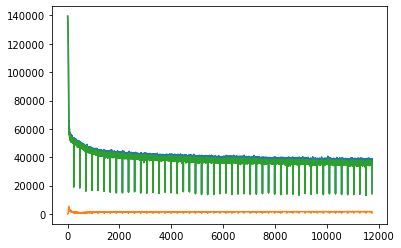

In [19]:
plt.plot(loss_log_list)
plt.plot(kl_log)
plt.plot(reconst_log)